### Importing Packages

In [ ]:
import os
import scipy
import nibabel as nib
from nilearn import plotting
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
import seaborn as sns

### Importing the data from the private drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = "/content/drive/MyDrive/Works/ADNIKAGGLE/NC"
file_names = os.listdir(folder_path)

# Initialize empty lists to store the images and labels
NC = []
NC_fmri = []
labels_NC = []
# Iterate over the files in the folder
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)

    # Read the image and get fmri data
    img = nib.load(file_path)
    img_data = img.get_fdata()

    # Resize image
    resized_data = scipy.ndimage.zoom(img_data, (0.5, 0.5, 0.5), order=1)

    # Save the resized image and get fmri data
    img_data= nib.Nifti1Image(resized_data, img.affine)
    img_data = img_data.get_fdata()

    # Add the image to the list of images and label it
    NC.append(img)
    NC_fmri.append(img_data)
    labels_NC.append([1,0,0])

NC_fmri = np.array(NC_fmri)

In [ ]:
folder_path = "/content/drive/MyDrive/Works/ADNIKAGGLE/MCI"
file_names = os.listdir(folder_path)

# Initialize empty lists to store the images and labels
MCI = []
MCI_fmri = []
labels_MCI = []
# Iterate over the files in the folder
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)

    # Read the image and get fmri data
    img = nib.load(file_path)
    img_data = img.get_fdata()

    # Resize image and get fmri data
    resized_data = scipy.ndimage.zoom(img_data, (0.5, 0.5, 0.5), order=1)

    # Save the resized imag and get fmri data
    img_data = nib.Nifti1Image(resized_data, img.affine)
    img_data = img_data.get_fdata()

    # Add the image to the list of images
    MCI.append(img)
    MCI_fmri.append(img_data)
    labels_MCI.append([0,1,0])

MCI_fmri = np.array(MCI_fmri)

In [ ]:
folder_path = "/content/drive/MyDrive/Works/ADNIKAGGLE/AD"
file_names = os.listdir(folder_path)

# Initialize empty lists to store the images and labels
AD = []
AD_fmri = []
labels_AD = []
# Iterate over the files in the folder
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)

    # Read the image and get fmri data
    img = nib.load(file_path)
    img_data = img.get_fdata()

    # Resize image and get fmri data
    resized_data = scipy.ndimage.zoom(img_data, (0.5, 0.5, 0.5), order=1)

    # Save the resized imag and get fmri data
    img_data = nib.Nifti1Image(resized_data, img.affine)
    img_data = img_data.get_fdata()

    # Add the image to the list of images
    AD.append(img)
    AD_fmri.append(img_data)
    labels_AD.append([0,0,1])

AD_fmri = np.array(AD_fmri)

## Presenting the images and the fmri data

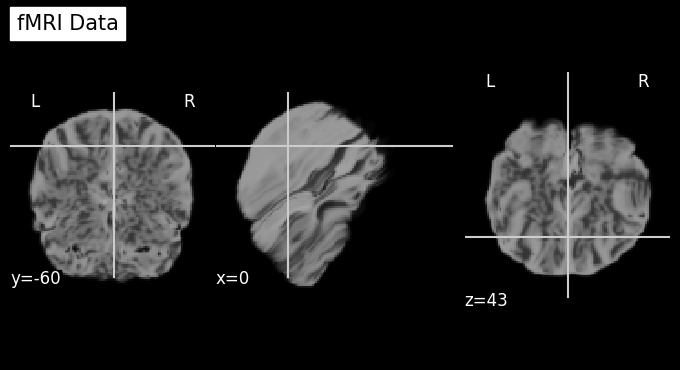

In [ ]:
plotting.plot_anat(NC[20].slicer[:, :, :], title=f'fMRI Data')

plotting.show()

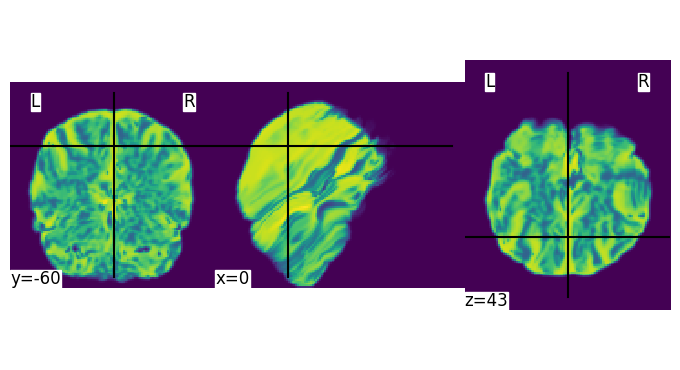

In [ ]:
plotting.plot_img(NC[20])
plotting.show()

### Preprocessing for fitting the 3D CNN model

In [ ]:
features = np.concatenate((NC_fmri,MCI_fmri,AD_fmri), axis=0)
NC_fmri,MCI_fmri,AD_fmri = 1,1,1

In [ ]:
labels = np.concatenate((labels_NC,labels_MCI,labels_AD), axis=0)

In [ ]:
x_size, y_size, z_size= features[200].shape

## The model

In [ ]:
model = models.Sequential()

# Convolutional layers
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=(x_size, y_size, z_size,1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
layers.Dropout(0.3)
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
layers.Dropout(0.3)
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Bootstrap

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features,labels,test_size=0.25,stratify=labels)

### Fitting and results (89% accuracy)

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=100)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test,y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test set
predictions = model.predict(x_test)

Epoch 1/100
22/22 [==============================] - 2s 82ms/step - loss: 1.0456 - accuracy: 0.7596 - val_loss: 1.4935 - val_accuracy: 0.5467
Epoch 2/100
22/22 [==============================] - 1s 65ms/step - loss: 0.6977 - accuracy: 0.7418 - val_loss: 0.9421 - val_accuracy: 0.6089
Epoch 3/100
22/22 [==============================] - 1s 65ms/step - loss: 0.4264 - accuracy: 0.8412 - val_loss: 0.6026 - val_accuracy: 0.8444
Epoch 4/100
22/22 [==============================] - 1s 65ms/step - loss: 0.2959 - accuracy: 0.9065 - val_loss: 0.6081 - val_accuracy: 0.8356
Epoch 5/100
22/22 [==============================] - 1s 65ms/step - loss: 0.2495 - accuracy: 0.9080 - val_loss: 0.7066 - val_accuracy: 0.8578
Epoch 6/100
22/22 [==============================] - 1s 65ms/step - loss: 0.1970 - accuracy: 0.9451 - val_loss: 0.6677 - val_accuracy: 0.8800
Epoch 7/100
22/22 [==============================] - 1s 65ms/step - loss: 0.1900 - accuracy: 0.9288 - val_loss: 0.6492 - val_accuracy: 0.8756
Epoch 

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 54, 66, 54, 64)    1792      
                                                                 
 max_pooling3d_14 (MaxPooli  (None, 27, 33, 27, 64)    0         
 ng3D)                                                           
                                                                 
 conv3d_15 (Conv3D)          (None, 25, 31, 25, 32)    55328     
                                                                 
 max_pooling3d_15 (MaxPooli  (None, 12, 15, 12, 32)    0         
 ng3D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 69120)             0         
                                                                 
 dense_12 (Dense)            (None, 128)              

### Confusion matrix and results

<Axes: >

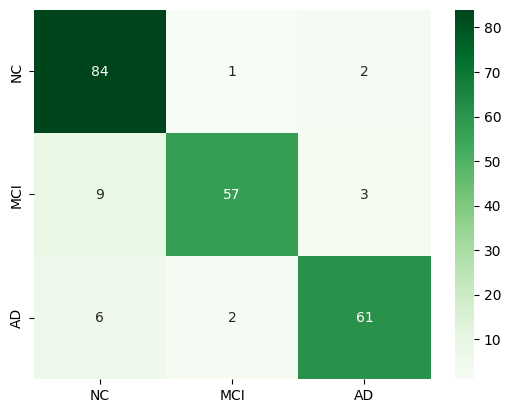

In [ ]:
y_test=np.argmax(y_test, axis=1)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_test, predictions),
  columns = ['NC','MCI', 'AD'],
  index = ['NC','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')